# Cloud Classification
---
Identify the type of cloud in the sky using deep transfer learning
___

**Author**: Aman Hussain  
**Email**: email at 'first name' + 'last name' dot com  
**Description**: Research notebook for cloud classification based on the appearance of clouds in the sky
___

## Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Configuration

In [3]:
np.random.seed(42)
DATA = Path("../data/")
CLASSES = ['cirrus', 'cumulus', 'stratus']

## Types of Cloud

**Source**: [WW2010 University of Illinois](http://ww2010.atmos.uiuc.edu/(Gh)/guides/mtr/cld/cldtyp/home.rxml)

Clouds are classified into a system that uses Latin words to describe the appearance of clouds as seen by an observer on the ground. The table below summarizes the four principal components of this classification system (Ahrens, 1994).

- cumulus (heap)
- stratus (layer)
- cirrus (curl of hair)
- nimbus (rain)

Further classification identifies clouds by height of cloud base. For example, cloud names containing the prefix "cirr-", as in cirrus clouds, are located at high levels while cloud names with the prefix "alto-", as in altostratus, are found at middle levels. This module introduces several cloud groups. The first three groups are identified based upon their height above the ground. The fourth group consists of vertically developed clouds, while the final group consists of a collection of miscellaneous cloud types. 

## Create Dataset

In [17]:
folder = 'cirrus'
dest = DATA/folder
dest.mkdir(parents=True, exist_ok=True)

In [18]:
download_images('../urls_cirrus.txt', dest)

In [19]:
folder = 'cumulus'
dest = DATA/folder
dest.mkdir(parents=True, exist_ok=True)

In [20]:
download_images('../urls_cumulus.txt', dest)

Error https://image.shutterstock.com/image-photo/blue-sky-cumulus-clouds-that-450w-752448991.jpg HTTPSConnectionPool(host='image.shutterstock.com', port=443): Read timed out. (read timeout=4)


In [21]:
folder = 'stratus'
dest = DATA/folder
dest.mkdir(parents=True, exist_ok=True)

In [22]:
download_images('../urls_stratus.txt', dest)

**Verify all images**

In [32]:
for c in CLASSES:
    print(c)
    verify_images(DATA/c, delete=True)

cirrus


cumulus


stratus


## Load Data

In [4]:
doc(ImageDataBunch.from_folder)

from_folder [source] from_folder ( `path` : PathOrStr , `train` : PathOrStr = `'train'` , `valid` : PathOrStr = `'valid'` , `valid_pct` = `None` , `classes` : Collection [ T_co ]= `None` , `kwargs` : Any ) → ImageDataBunch 
 
 Create from imagenet style dataset in path with train , valid , test subfolders (or provide valid_pct ). 
 Show in docs

**NOTES: Batch size for smaller datasets should be small**

In [5]:
data = ImageDataBunch.from_folder(DATA, train=".", valid_pct=0.2, size=224, bs=10)

In [6]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (232 items)
[Category cirrus, Category cirrus, Category cirrus, Category cirrus, Category cirrus]...
Path: ../data
x: ImageItemList (232 items)
[Image (3, 154, 275), Image (3, 311, 450), Image (3, 657, 960), Image (3, 683, 1024), Image (3, 1167, 1600)]...
Path: ../data;

Valid: LabelList
y: CategoryList (57 items)
[Category cirrus, Category cumulus, Category stratus, Category cirrus, Category cumulus]...
Path: ../data
x: ImageItemList (57 items)
[Image (3, 2864, 4288), Image (3, 975, 1300), Image (3, 480, 852), Image (3, 288, 450), Image (3, 4000, 6016)]...
Path: ../data;

Test: None

## Exploratory Data Analysis

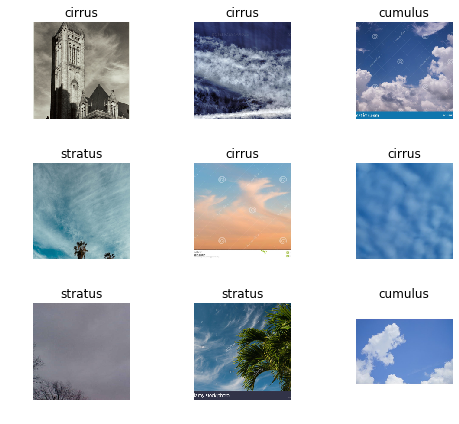

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
data.classes

['cirrus', 'cumulus', 'stratus']

In [9]:
data.c

3

In [10]:
len(data.train_ds)

232

In [11]:
len(data.valid_ds)

57

In [12]:
data.batch_size

10

## Train Model: Resnet34 already trained on Imagenet 

In [13]:
doc(create_cnn)

create_cnn [source] create_cnn ( `data` : DataBunch , `arch` : Callable , `cut` : Union [ int , Callable ]= `None` , `pretrained` : bool = `True` , `lin_ftrs` : Optional [ Collection [ int ]]= `None` , `ps` : Floats = `0.5` , `custom_head` : Optional [ Module ]= `None` , `split_on` : Union [ Callable , Collection [ ModuleList ], NoneType ]= `None` , `bn_final` : bool = `False` , `kwargs` : Any ) → Learner 
 
 Build convnet style learners. 
 Show in docs

In [19]:
learner = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

In [41]:
print(learner.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 112, 112]   9408       False     
______________________________________________________________________
BatchNorm2d          [32, 64, 112, 112]   128        True      
______________________________________________________________________
ReLU                 [32, 64, 112, 112]   0          False     
______________________________________________________________________
MaxPool2d            [32, 64, 56, 56]     0          False     
______________________________________________________________________
Conv2d               [32, 64, 56, 56]     36864      False     
______________________________________________________________________
BatchNorm2d          [32, 64, 56, 56]     128        True      
______________________________________________________________________
ReLU                 [32, 64, 56, 56]     0          False     
______________________________________________________________

In [20]:
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy
1,1.043148,0.727070,0.245614,0.754386
2,0.880051,0.630914,0.175439,0.824561
3,0.713131,0.622179,0.210526,0.789474


**NOTES:** The model seems to have overfit because train_loss has gone below validation_loss. Need to train for three epochs only.  
**NOTES:** Lowering the batch size and training epochs gets to a good optimized accuracy. Need to improve it further

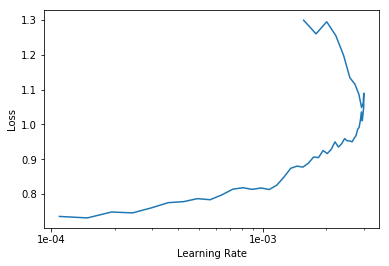

In [21]:
learner.recorder.plot()

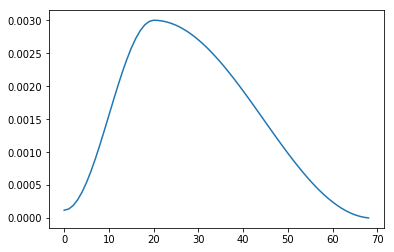

In [22]:
learner.recorder.plot_lr()

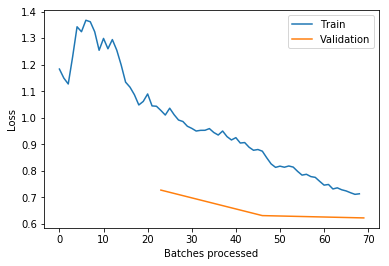

In [23]:
learner.recorder.plot_losses()

**NOTES:** The loss plot looks standard enough

## Save Model

In [24]:
learner.save('stage-1')

## Results

In [25]:
doc(ClassificationInterpretation)

class ClassificationInterpretation [source] ClassificationInterpretation ( `data` : DataBunch , `probs` : Tensor , `y_true` : Tensor , `losses` : Tensor ) 
 
 Interpretation methods for classification models. 
 Show in docs

In [26]:
interp = ClassificationInterpretation.from_learner(learner)

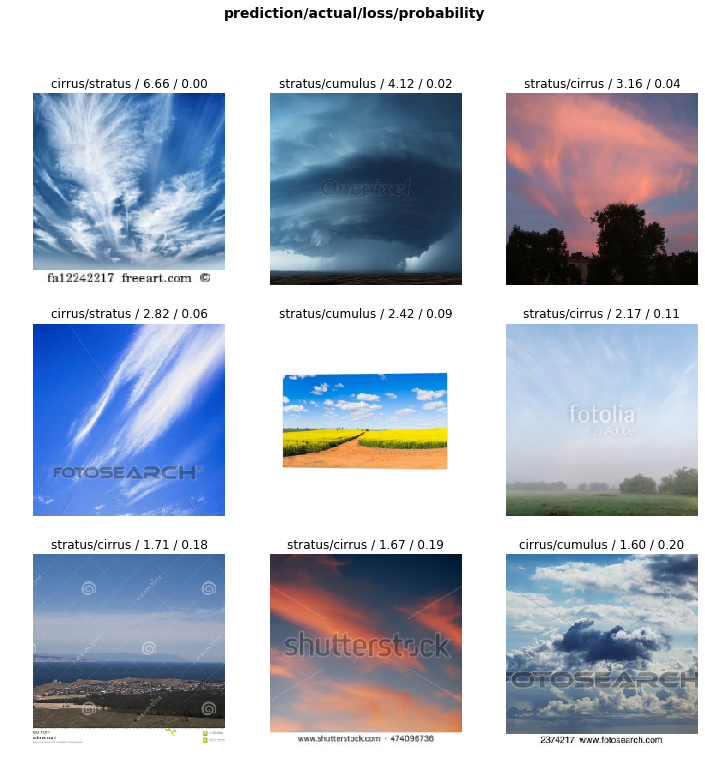

In [27]:
interp.plot_top_losses(9)

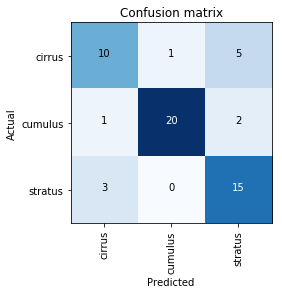

In [28]:
interp.plot_confusion_matrix()

**NOTES:** Stratus and cirrus are mostly confused with each other. Model seems to be doing well with cumulus as expected.

## Finetune Model

**Train a model from scratch to see the error introduced by transfer learning if any**

In [31]:
learner.unfreeze()

In [33]:
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.597968,1.086756,0.298246,0.701754
2,0.598718,0.778886,0.210526,0.789474


**NOTES:** When the entire network is trained, it results in the same accuracy.

**Finetune model with differential learning rate**

In [35]:
learner.load('stage-1');

In [36]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


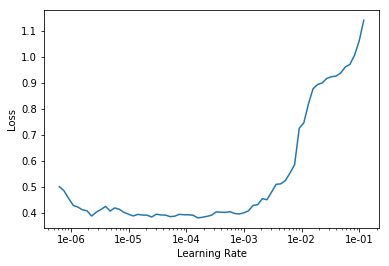

In [37]:
learner.recorder.plot()

**NOTES:** 1e-05 seems like the best learning rate

In [38]:
learner.unfreeze()

In [39]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.485308,0.660685,0.210526,0.789474
2,0.493899,0.644485,0.210526,0.789474
3,0.434782,0.662940,0.228070,0.771930


**NOTES:** Overfitting and the accuracy has decreased

## Save Model

In [40]:
learner.save('stage-2')

## Results

In [41]:
interp = ClassificationInterpretation.from_learner(learner)

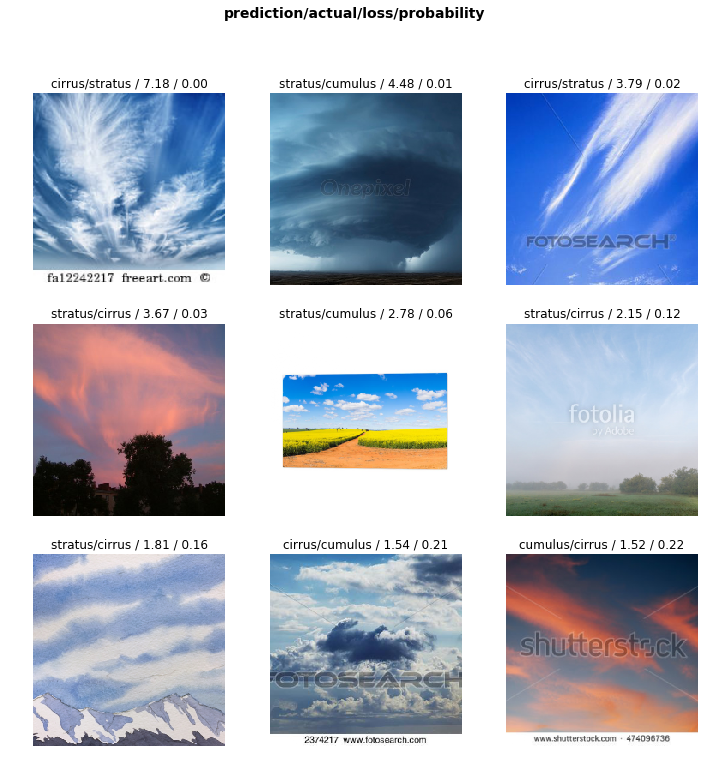

In [42]:
interp.plot_top_losses(9)

## Data Cleaning

In [46]:
from fastai.widgets import *

In [49]:
doc(DatasetFormatter.from_toplosses)

from_toplosses [source] from_toplosses ( `learn` , `n_imgs` = `None` , `kwargs` ) 
 
 Gets indices with top losses. 
 Show in docs

In [50]:
ds, idxs = DatasetFormatter.from_toplosses(learner)

In [52]:
ImageCleaner(ds, idxs, DATA)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Retraining

## Load Data

In [4]:
doc(ImageDataBunch.from_df)

from_df [source] from_df ( `path` : PathOrStr , `df` : DataFrame , `folder` : PathOrStr = `'.'` , `label_delim` : str = `None` , `valid_pct` : float = `0.2` , `fn_col` : IntsOrStrs = `0` , `label_col` : IntsOrStrs = `1` , `suffix` : str = `''` , `kwargs` : Any ) → ImageDataBunch 
 
 Create from a DataFrame df . 
 Show in docs

In [5]:
old_data = ImageDataBunch.from_folder(DATA, train=".", valid_pct=0.2, size=224, bs=10)

In [6]:
df = pd.read_csv(DATA/'cleaned.csv', header='infer')

In [7]:
data = ImageDataBunch.from_df(DATA, df, valid_pct=0.0, size=224, bs=10)

In [8]:
data.valid_dl = old_data.valid_dl

In [9]:
len(data.valid_ds)

57

In [10]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (231 items)
[Category cirrus, Category cirrus, Category cirrus, Category cirrus, Category cirrus]...
Path: ../data
x: ImageItemList (231 items)
[Image (3, 154, 275), Image (3, 311, 450), Image (3, 657, 960), Image (3, 683, 1024), Image (3, 1167, 1600)]...
Path: ../data;

Valid: LabelList
y: CategoryList (57 items)
[Category cirrus, Category cumulus, Category stratus, Category cirrus, Category cumulus]...
Path: ../data
x: ImageItemList (57 items)
[Image (3, 2864, 4288), Image (3, 975, 1300), Image (3, 480, 852), Image (3, 288, 450), Image (3, 4000, 6016)]...
Path: ../data;

Test: None

## Exploratory Data Analysis

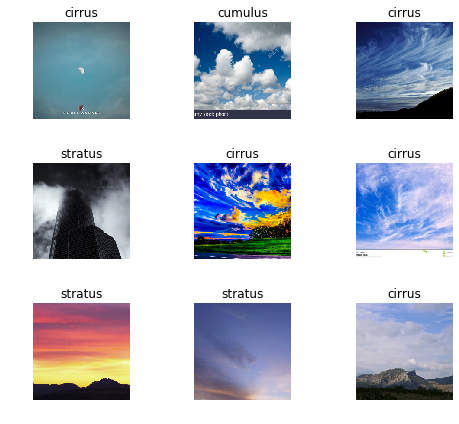

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
data.classes

['cirrus', 'cumulus', 'stratus']

In [13]:
data.c

3

In [14]:
data.sanity_check()

In [15]:
len(data.train_ds)

231

In [16]:
len(data.valid_ds)

57

In [17]:
data.batch_size

10

## Train Model: Resnet34 already trained on Imagenet 

In [18]:
doc(create_cnn)

create_cnn [source] create_cnn ( `data` : DataBunch , `arch` : Callable , `cut` : Union [ int , Callable ]= `None` , `pretrained` : bool = `True` , `lin_ftrs` : Optional [ Collection [ int ]]= `None` , `ps` : Floats = `0.5` , `custom_head` : Optional [ Module ]= `None` , `split_on` : Union [ Callable , Collection [ ModuleList ], NoneType ]= `None` , `bn_final` : bool = `False` , `kwargs` : Any ) → Learner 
 
 Build convnet style learners. 
 Show in docs

In [19]:
learner = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

In [41]:
print(learner.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 64, 112, 112]   9408       False     
______________________________________________________________________
BatchNorm2d          [32, 64, 112, 112]   128        True      
______________________________________________________________________
ReLU                 [32, 64, 112, 112]   0          False     
______________________________________________________________________
MaxPool2d            [32, 64, 56, 56]     0          False     
______________________________________________________________________
Conv2d               [32, 64, 56, 56]     36864      False     
______________________________________________________________________
BatchNorm2d          [32, 64, 56, 56]     128        True      
______________________________________________________________________
ReLU                 [32, 64, 56, 56]     0          False     
______________________________________________________________

In [20]:
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy
1,1.126839,0.686749,0.263158,0.736842
2,0.786629,0.724146,0.210526,0.789474


In [21]:
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.545942,0.706930,0.228070,0.771930
2,0.463571,0.704676,0.245614,0.754386


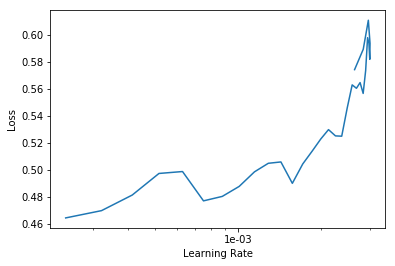

In [22]:
learner.recorder.plot()

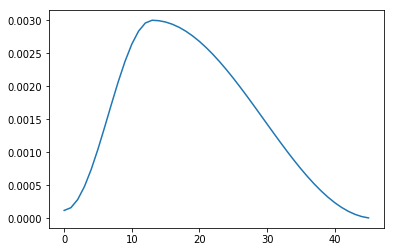

In [23]:
learner.recorder.plot_lr()

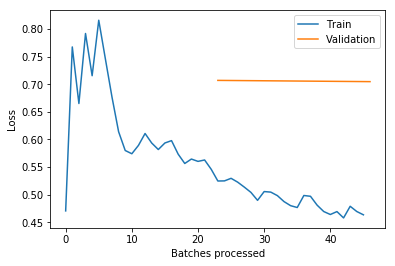

In [24]:
learner.recorder.plot_losses()

## Save Model

In [115]:
learner.save('stage-3')

## Results

In [116]:
doc(ClassificationInterpretation)

class ClassificationInterpretation [source] ClassificationInterpretation ( `data` : DataBunch , `probs` : Tensor , `y_true` : Tensor , `losses` : Tensor ) 
 
 Interpretation methods for classification models. 
 Show in docs

In [25]:
interp = ClassificationInterpretation.from_learner(learner)

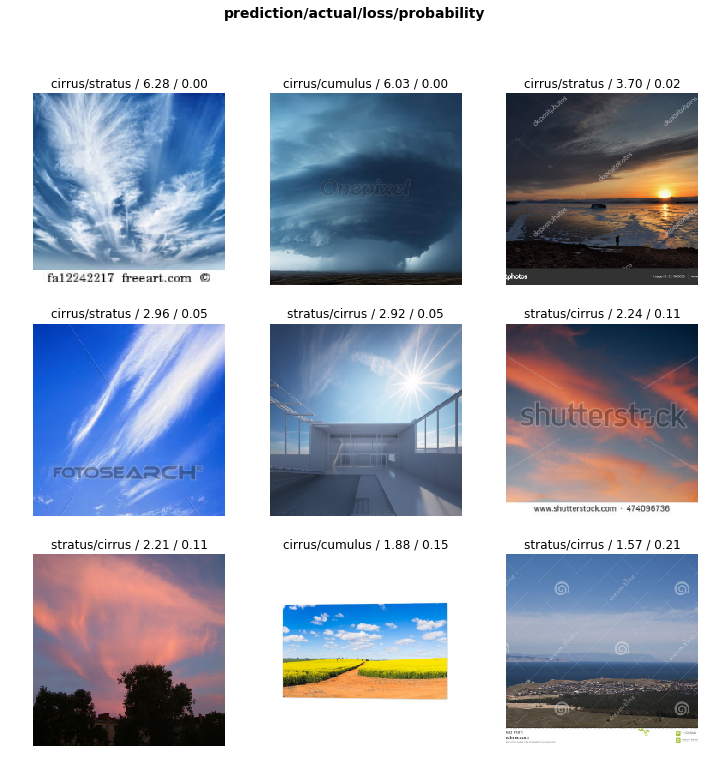

In [26]:
interp.plot_top_losses(9)

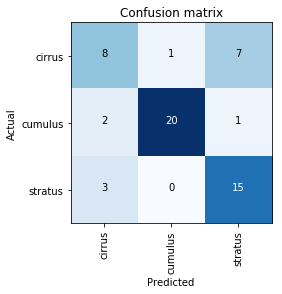

In [27]:
interp.plot_confusion_matrix()

**NOTES:** Stratus and cirrus are mostly confused with each other. Model seems to be doing well with cumulus as expected.

## Finetune Model

**Train a model from scratch to see the error introduced by transfer learning if any**

In [120]:
learner.unfreeze()

In [121]:
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.611540,0.745059,0.228070,0.771930
2,0.628323,0.383773,0.140351,0.859649


In [122]:
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.387787,0.340437,0.105263,0.894737
2,0.306588,0.083361,0.017544,0.982456


**Finetune model with differential learning rate**

In [21]:
learner.load('stage-3');

In [124]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


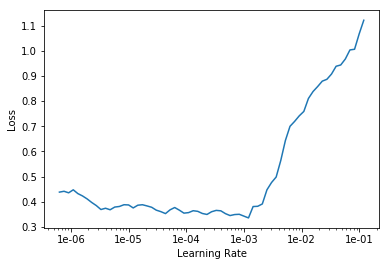

In [125]:
learner.recorder.plot()

**NOTES:** 1e-4 seems like the best learning rate

In [22]:
learner.unfreeze()

In [23]:
learner.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.359069,0.704110,0.298246,0.701754
2,0.352612,0.656662,0.280702,0.719298
3,0.321263,0.655876,0.298246,0.701754
4,0.298392,0.626346,0.245614,0.754386


## Training from scratch

In [41]:
learner = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

In [42]:
learner.unfreeze()

In [43]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,accuracy
1,1.134744,0.670940,0.192982,0.807018
2,0.734170,1.077704,0.298246,0.701754
3,0.620519,0.962309,0.263158,0.736842
4,0.553581,1.188047,0.333333,0.666667
5,0.514727,0.874232,0.245614,0.754386
6,0.434931,0.806287,0.280702,0.719298
7,0.335548,0.872615,0.280702,0.719298
8,0.267237,0.890233,0.298246,0.701754


## Save Model

In [40]:
learner.save('stage-4')

## Results

In [33]:
learner = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

In [34]:
learner.load('stage-3');

In [35]:
interp = ClassificationInterpretation.from_learner(learner)

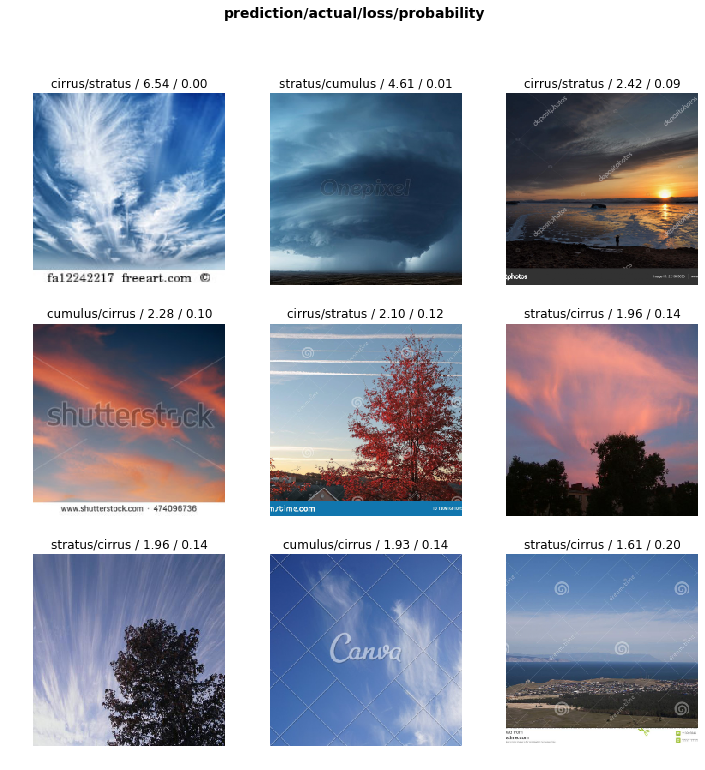

In [36]:
interp.plot_top_losses(9)

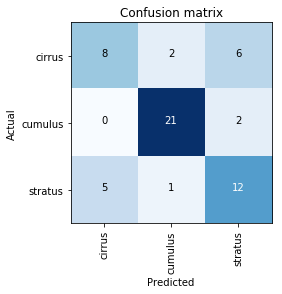

In [37]:
interp.plot_confusion_matrix()

**Need to run the entire process again**